In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,roc_auc_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.manifold import Isomap
from sklearn.metrics.pairwise import pairwise_distances



from astropy.io import ascii
from utils import col_names, normalise_sdss_class, ellipticity, filling_factor
import matplotlib.pyplot as plt
%matplotlib inline

In [62]:
relevant_indices = [6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]

In [74]:
datasets = "../datasets/SuperCOSMOS/"

#load data
uki823_df = ascii.read(datasets + "UKI823/sssedrpair.dat", guess=False, Reader=ascii.FastNoHeader).to_pandas()

#Get relevant column names
colnames_relevant=[col_names[i] for i in relevant_indices]

#Get Relevant columns
data=uki823_df.iloc[:, relevant_indices]

#Create data framhttp://localhost:8888/notebooks/Masters/DME/Project/dme-mini-project/notebooks/classification_with_cols_19_21.ipynb#e
data = pd.DataFrame(data.values, columns = colnames_relevant)   

#Add in ellipticity, filling factor and normalise CLASS_SDSS
data['Ellipticity'] =  ellipticity(uki823_df.iloc[:,15],uki823_df.iloc[:,16])
data['Filling Factor']= filling_factor(data['AREA'], uki823_df.iloc[:,12],uki823_df.iloc[:,13])
normalise_sdss_class(data)


#One Hot Encode

In [76]:
enc = OneHotEncoder()
X=enc.fit_transform(data['CLASS'].values.reshape(-1,1)).toarray()


C:\Users\jsmyt\Anaconda3\envs\dme_project\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [79]:
dfOneHot = pd.DataFrame(X, columns = ["Class_"+str(int(i)) for i in range(X.shape[1])])
data = pd.concat([data, dfOneHot], axis=1)

#Remove Col class
data = data.drop("CLASS", axis=1) 

In [80]:
#Seperate data into variables and classification
data_x=data.loc[:,data.columns!='CLASS_SDSS']
data_y=data['CLASS_SDSS']

In [82]:
#Split dataset into train, val, test
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import log_loss

X_train,X_test,y_train,y_test = train_test_split(data_x,data_y,test_size=0.1,random_state=1)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=2./9,random_state=1)

sc = StandardScaler().fit(X_train)
X_train_sc = sc.transform(X_train)
X_val_sc = sc.transform(X_val)
X_test_sc = sc.transform(X_test)

random_state = 1

#Cross Validated Backwards Elimination using SVM




Optimal number of features : 17


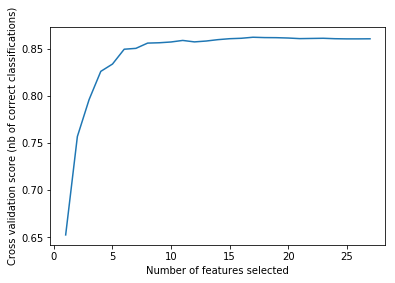

In [84]:

# import matplotlib.pyplot as plt
# from sklearn.svm import SVC
# from sklearn.model_selection import StratifiedKFold
# from sklearn.feature_selection import RFECV
# from sklearn.datasets import make_classification

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(X_train_sc, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [85]:
# rfecv.ranking_ gives indexes which are kept

In [86]:
#Get indices of most important variables
ind_list=[]
for i in range(len(X_train.columns)):
    if rfecv.ranking_[i] == 1:
        ind_list.append(i)

bwe_data_train=X_train_sc[:,ind_list]
bwe_data_val=X_val_sc[:,ind_list]
bwe_data_test=X_test_sc[:,ind_list]

In [87]:
print('Order of colums originally: ', X_train.columns)
print('\n')
print('Indexes of variables selected: ',ind_list)
print('\n')
print('Actual variables selected: ',X_train.columns[ind_list])


Order of colums originally:  Index(['AREA', 'IPEAK', 'COSMAG', 'ISKY', 'A_U', 'B_U', 'THETA_U', 'A_I',
       'B_I', 'THETA_I', 'BLEND', 'QUALITY', 'N(0,1)', 'PRFMAG', 'C_COSMAG',
       'C_PRFMAG', 'RA_SDSS', 'DEC_SDSS', 'GMAG_SDSS', 'RMAG_SDSS',
       'IMAG_SDSS', 'Ellipticity', 'Filling Factor', 'Class_0', 'Class_1',
       'Class_2', 'Class_3'],
      dtype='object')


Indexes of variables selected:  [0, 1, 2, 3, 4, 5, 7, 8, 13, 14, 15, 18, 19, 20, 21, 22, 26]


Actual variables selected:  Index(['AREA', 'IPEAK', 'COSMAG', 'ISKY', 'A_U', 'B_U', 'A_I', 'B_I', 'PRFMAG',
       'C_COSMAG', 'C_PRFMAG', 'GMAG_SDSS', 'RMAG_SDSS', 'IMAG_SDSS',
       'Ellipticity', 'Filling Factor', 'Class_3'],
      dtype='object')


#Do classification using features selected with backwards elimination

In [ ]:


names = ["Logistic Regression", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net (Multi-layer perceptron)"]

classifiers = [
    LogisticRegression(),
    SVC(kernel="linear", probability=True, random_state=random_state),
    SVC(kernel='rbf', probability=True, random_state=random_state),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(max_depth=10, n_estimators=50,random_state=random_state),
    MLPClassifier(max_iter=1000, random_state=random_state)]

ca_score = {} # Classification accuracy
F1_scores = {} #F1 scores

for name, clf in zip(names, classifiers):
    clf.fit(bwe_data_train, y_train)
    ca_score[name] = clf.score(bwe_data_val, y_val)
    F1_scores[name] = f1_score(y_val,clf.predict(bwe_data_val),average='macro')
    
print('Classification performance on validation set:')
for clf in names:
    print ("{}, accuracy: {:.3f}, f1-score: {:.3f}".format(clf, ca_score[clf],F1_scores[clf]))

Tune hyperparameters of a MLP classifier

In [88]:
# Your code goes here
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


cv = KFold(n_splits=3, shuffle=True, random_state=random_state)
mlp_clf = MLPClassifier(random_state=random_state)

def objective_mlp(params):
    number_hidden_units, alpha = params

    mlp_clf.set_params(hidden_layer_sizes = (number_hidden_units,),
                      alpha=alpha)

    return -np.mean(cross_val_score(mlp_clf, X_train_sc, y_train, cv=cv, n_jobs=-1,
                                    scoring="accuracy"))

space  = [(10, 1000),                       # number of hidden units
          (10**-8, 1)]                      # alpha
x0 = [100, 10**-4]

In [89]:
from skopt import gp_minimize

res_gp = gp_minimize(objective_mlp, space, x0=x0, n_calls=25, random_state=random_state, n_random_starts=5)
print("Best score with Bayesian optimisation: {:.3f}".format(res_gp.fun))
print("Best parameters with Bayesian optimisation:\n-hidden layer size: ({},)\n-alpha: {}"
      .format(res_gp.x[0],res_gp.x[1]))

Best score with Bayesian optimisation: -0.889
Best parameters with Bayesian optimisation:
-hidden layer size: (32,)
-alpha: 0.0013355668851875754


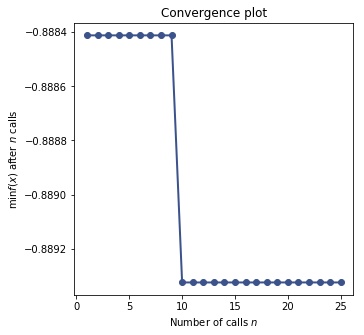

In [90]:
# Convergence plot
from skopt.plots import plot_convergence

plt.figure(figsize=(5,5))
plot_convergence(res_gp)
plt.grid()
plt.show()

MLP with optimal parameters using all relevant variables variables

In [91]:
# Train final model and report accuracy on validation and test sets
from sklearn.metrics import accuracy_score

mlp_opt = MLPClassifier(random_state=random_state,
                        hidden_layer_sizes = (res_gp.x[0],),
                        alpha=res_gp.x[1])
mlp_opt.fit(X_train_sc,y_train)
print("Classification accuracy on validation set: {:.3f}".format(accuracy_score(y_val, mlp_opt.predict(X_val_sc))))
print("Classification accuracy on test set: {:.3f}".format(accuracy_score(y_test, mlp_opt.predict(X_test_sc))))

Classification accuracy on validation set: 0.901
Classification accuracy on test set: 0.899


C:\Users\jsmyt\Anaconda3\envs\dme_project\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP with optimal parameters using Backwards Eliminated variables

In [92]:
# Train final model and report accuracy on validation and test sets
from sklearn.metrics import accuracy_score

mlp_opt = MLPClassifier(random_state=random_state,
                        hidden_layer_sizes = (res_gp.x[0],),
                        alpha=res_gp.x[1])
mlp_opt.fit(bwe_data_train,y_train)
print("Classification accuracy on validation set: {:.3f}".format(accuracy_score(y_val, mlp_opt.predict(bwe_data_val))))
print("Classification accuracy on test set: {:.3f}".format(accuracy_score(y_test, mlp_opt.predict(bwe_data_test))))

Classification accuracy on validation set: 0.899
Classification accuracy on test set: 0.904


C:\Users\jsmyt\Anaconda3\envs\dme_project\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Isomap

In [95]:
def scatter_2d_label(X_2d, y, s=2, alpha=0.5, lw=2):
    """Visualuse a 2D embedding with corresponding labels.
    
    X_2d : ndarray, shape (n_samples,2)
        Low-dimensional feature representation.
    
    y : ndarray, shape (n_samples,)
        Labels corresponding to the entries in X_2d.
        
    s : float
        Marker size for scatter plot.
    
    alpha : float
        Transparency for scatter plot.
        
    lw : float
        Linewidth for scatter plot.
    """
    targets = np.unique(y)
    colors = sns.color_palette(n_colors=targets.size)
    for color, target in zip(colors, targets):
        plt.scatter(X_2d[y == target, 0], X_2d[y == target, 1], color=color, label=target, s=s, alpha=alpha, lw=lw)

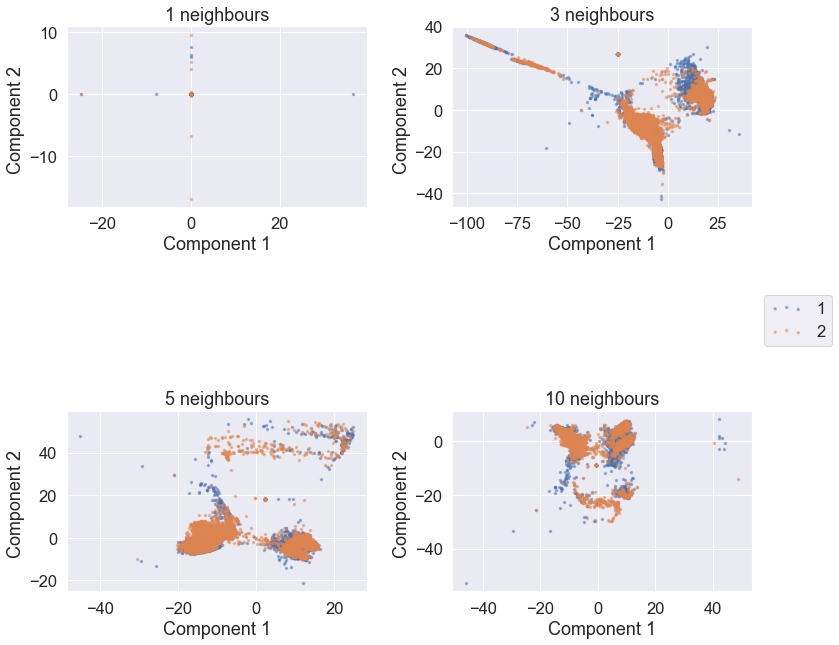

In [97]:
from sklearn.manifold import Isomap
sns.set(font_scale=1.5) # Set default font size
fig, ax = plt.subplots(2,2,figsize=(12,14))
for ii, n_neighbors in enumerate([1, 3, 5, 10]):
    ismp = Isomap(n_components=2, n_neighbors=n_neighbors)
    X_ismp_2d = ismp.fit_transform(X_train_sc)
    plt.subplot(3,2,ii+1)
    scatter_2d_label(X_ismp_2d, y_train)
    plt.title('{} neighbours'.format(n_neighbors))
    plt.xlabel('Component 1')
    plt.ylabel('Component 2 ')
plt.legend(loc='center left', bbox_to_anchor=[1.01, 1.5], scatterpoints=3)
fig.tight_layout()
plt.show()